In [58]:
import re
import random
import pandas as pd
import hashlib

In [59]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.75) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(.75) for _ in cards_to_age.index]


cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('age')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [60]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,head_count
Network Vocab,29.693592,1.237233,24
Logging in Python,244.623927,9.784957,25
Finance Junk,408.956751,136.318917,3
SharePoint,703.919088,41.407005,17
Azure Functions,727.218325,66.110757,11
Azure AI Search,820.814242,58.629589,14
Home Network Project,1103.062275,84.850944,13
Lost in a Good Book,1198.553430,59.927672,20
PP365,1221.828564,135.758729,9
Taxes,1251.407964,125.140796,10


# Histogram

49054.35


<Axes: >

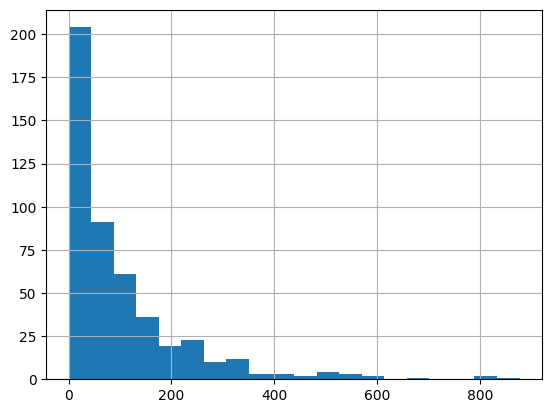

In [61]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [62]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

In [63]:
65e3/1000*40/60

43.333333333333336

# Age Sort

In [64]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [65]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [66]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [67]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [68]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [69]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle

## Random

In [70]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

## Age Sum

In [71]:
# n=4
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)
# existing_cards.head(10)

# remake_card_document(existing_cards=existing_cards)

## Age max

In [72]:
# n = 6
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [73]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)



## Card Count

In [74]:
n=3
existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'frequency', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)



Cards found: 477


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,count,n_fold
0,Finance Junk,Subordination of AT1 Bond: An AT1 Bond is deep...,0487e256c17983a0473fe49ba87be777,-158.505891,-136.318917,158.505891,408.956751,0.190037,3,0,0
1,Finance Junk,Loss-Absorption Trigger in AT1 Bond: An AT1 Bo...,3121f3eb78434ccfe67f5458600de1e1,-149.235414,-136.318917,158.505891,408.956751,0.190037,3,1,0
2,Finance Junk,Difference from Traditional Convertibles in AT...,0af31386c50171c90f4aad6a1c9ac591,-101.215446,-136.318917,158.505891,408.956751,0.190037,3,2,0
3,Diffusers Library,Likelihood Estimation\nThe process of calculat...,f6ee714e6a98efeb6b1bbad8a3c80c5b,-402.803312,-185.107777,402.803312,1665.969995,0.408192,9,0,0
4,Diffusers Library,Stochastic Differential Equations (SDEs)\nThes...,156a34280c42128b66ec481fa994ea63,-347.593910,-185.107777,402.803312,1665.969995,0.408192,9,1,0
5,Diffusers Library,There are three main components of the library...,f7e3a6c7776d532b620a40e49d354373,-325.866744,-185.107777,402.803312,1665.969995,0.408192,9,2,0
6,PP365,Plugin Registration Tool\nA utility provided b...,b84194a3b222e36229d9dc4f6c549892,-240.043806,-135.758729,240.043806,1221.828564,0.198667,9,0,0
7,PP365,Ribbon\nThe toolbar interface in Dynamics 365 ...,5d3ca68fb5245cc57ecc268ccb96ef50,-239.415577,-135.758729,240.043806,1221.828564,0.198667,9,1,0
8,PP365,I had a ticket with Lauren Kawamoto going back...,df019710fcf9dfdc9f4c2beadb6569aa,-205.010838,-135.758729,240.043806,1221.828564,0.198667,9,2,0
9,Taxes,Penalties for Non-Compliance: Civil penalties ...,ac4380a8b0bf5d453b538c181f0b5d72,-393.842337,-125.140796,393.842337,1251.407964,0.154890,10,0,0


In [75]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,count,n_fold
0,Finance Junk,Subordination of AT1 Bond: An AT1 Bond is deep...,0487e256c17983a0473fe49ba87be777,-158.505891,-136.318917,158.505891,408.956751,0.190037,3,0,0
1,Finance Junk,Loss-Absorption Trigger in AT1 Bond: An AT1 Bo...,3121f3eb78434ccfe67f5458600de1e1,-149.235414,-136.318917,158.505891,408.956751,0.190037,3,1,0
2,Finance Junk,Difference from Traditional Convertibles in AT...,0af31386c50171c90f4aad6a1c9ac591,-101.215446,-136.318917,158.505891,408.956751,0.190037,3,2,0
3,Diffusers Library,Likelihood Estimation\nThe process of calculat...,f6ee714e6a98efeb6b1bbad8a3c80c5b,-402.803312,-185.107777,402.803312,1665.969995,0.408192,9,0,0
4,Diffusers Library,Stochastic Differential Equations (SDEs)\nThes...,156a34280c42128b66ec481fa994ea63,-347.593910,-185.107777,402.803312,1665.969995,0.408192,9,1,0
5,Diffusers Library,There are three main components of the library...,f7e3a6c7776d532b620a40e49d354373,-325.866744,-185.107777,402.803312,1665.969995,0.408192,9,2,0
6,PP365,Plugin Registration Tool\nA utility provided b...,b84194a3b222e36229d9dc4f6c549892,-240.043806,-135.758729,240.043806,1221.828564,0.198667,9,0,0
7,PP365,Ribbon\nThe toolbar interface in Dynamics 365 ...,5d3ca68fb5245cc57ecc268ccb96ef50,-239.415577,-135.758729,240.043806,1221.828564,0.198667,9,1,0
8,PP365,I had a ticket with Lauren Kawamoto going back...,df019710fcf9dfdc9f4c2beadb6569aa,-205.010838,-135.758729,240.043806,1221.828564,0.198667,9,2,0
9,Taxes,Penalties for Non-Compliance: Civil penalties ...,ac4380a8b0bf5d453b538c181f0b5d72,-393.842337,-125.140796,393.842337,1251.407964,0.154890,10,0,0


In [76]:
existing_cards.head(10)['age'].sum()

np.float64(-2563.53327466255)